<a href="https://colab.research.google.com/github/swlee23/Deep-Learning-Time-Series-Anomaly-Detection/blob/master/DeepAnT_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Things to be included
# 1. visualization tools for optimization
# 2. visualization tools for plotting actual and predicted sequence, and anomaly points
# 3. Computation cost calculation
# 4. Warnings / Errors?

In [0]:
import numpy as np
from numpy import array
import random
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from keras.optimizers import SGD

In [0]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [0]:
              """Hyperparameters"""
input_seq_len = 500      # Length of input sequence (chopped from raw_sequence)
w = 50                   # History window (number of time stamps taken into account) 
                         # i.e., filter(kernel) size       
p_w = 1                  # Prediction window (number of time stampes required to be 
                         # predicted)

num_filt_1 = 32          # Number of filters in first conv layer
num_filt_2 = 32          # Number of filters in second conv layer
num_nrn_dl = 40          # Number of neurons in dense layer
num_nrn_ol = p_w         # Number of neurons in output layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

epochs = 30
dropout_rate = 0.5       # Dropout rate in the fully connected layer
learning_rate = 2e-5  
anm_det_thr = 0.8        # Threshold for classifying anomaly (0.5~0.8)

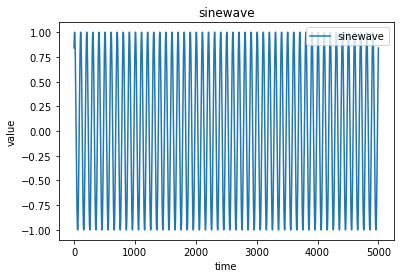

<Figure size 7200x720 with 0 Axes>

In [49]:
                """Data loading"""
df = pd.read_csv('https://raw.githubusercontent.com/swlee23/Deep-Learning-Time-Series-Anomaly-Detection/master/data/sinewave.csv')
plt.plot(df['sinewave'])
plt.title('sinewave')
plt.ylabel('value')
plt.xlabel('time')
plt.legend(['sinewave'], loc='upper right')
plt.figure(figsize=(100,10))
plt.show()



In [0]:
              """Data preprocessing"""
# split a univariate sequence into samples
def split_sequence(raw_seq, n_steps, prediction_seq_len):
	batch_sample, batch_label = list(), list()
	for i in range(len(raw_seq)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(raw_seq)-prediction_seq_len:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = raw_seq[i:end_ix], raw_seq[end_ix:end_ix + prediction_seq_len]
		batch_sample.append(seq_x)
		batch_label.append(seq_y)
	return array(batch_sample), array(batch_label)

# define input sequence
raw_seq = list(df['sinewave'])

# length of one sample sequence in batch
n_steps = input_seq_len

# choose length of prediction sequence
prediction_seq_len = p_w

# split into samples
batch_sample, batch_label = split_sequence(raw_seq, n_steps, prediction_seq_len)

# summarize the data
# for i in range(5):
# 	print(X[i], Y[i])
  
# 2. reshape from [samples, timesteps] into [samples, timesteps, features]
# univariate time series
n_features = 1
# need to convert batch into 3D tensor of the form [batch_size, input_seq_len, n_features]
batch_sample = batch_sample.reshape((batch_sample.shape[0], batch_sample.shape[1], n_features))

if prediction_seq_len > 1:
    batch_label = batch_label.reshape((batch_label.shape[0], batch_label.shape[1], n_features))

In [27]:
              """Generate model for predictor"""
model = Sequential()

# Convolutional Layer #1
# Computes 32 features using a 1D filter(kernel) of with w with ReLU activation. 
# Padding is added to preserve width.
# Input Tensor Shape: [batch_size, input_seq_len, 1] / batch_size = len(batch_sample)
# Output Tensor Shape: [batch_size, w, num_filt_1] (num_filt_1 = 32 feature vectors)
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=w,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(input_seq_len, p_w)))

# Pooling Layer #1
# First max pooling layer with a filter of length 2 and stride of 2
# Input Tensor Shape: [batch_size, w, num_filt_1]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1]

model.add(MaxPooling1D(pool_size=pool_size_1)) 
                    #  strides=pool_strides_1, 
                    #  padding='valid'))

# Convolutional Layer #2
# Computes 64 features using a 5x5 filter.
# Padding is added to preserve width and height.
# Input Tensor Shape: [batch_size, 0.5 * w, 32]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=w,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))

# Max Pooling Layer #2
# Second max pooling layer with a 2x2 filter and stride of 2
# Input Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
model.add(MaxPooling1D(pool_size=pool_size_2))
                    #  strides=pool_strides_2, 
                    #  padding='valid'
          
# Flatten tensor into a batch of vectors
# Input Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
model.add(Flatten())

# Dense Layer (Output layer)
# Densely connected layer with 1024 neurons
# Input Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 1024]
model.add(Dense(units=num_nrn_dl, activation='relu'))  

# Dropout
# Prevents overfitting in deep neural networks
model.add(Dropout(dropout_rate))

# Output layer
# Input Tensor Shape: [batch_size, 1024]
# Output Tensor Shape: [batch_size, p_w]
model.add(Dense(units=num_nrn_ol))

# Summarize model structure
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 451, 32)           1632      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 225, 32)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 176, 32)           51232     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 88, 32)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2816)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 40)                112680    
_________________________________________________________________
dropout_4 (Dropout)          (None, 40)                0         
__________

In [0]:
               '''configure model'''
model.compile(optimizer='adam', 
              loss='mean_absolute_error')

# sgd = keras.optimizers.SGD(lr=learning_rate, 
#                          decay=1e-6, 
#                          momentum=0.9, 
#                          nesterov=True)
# model.compile(optimizer='sgd', 
#               loss='mean_absolute_error', 
#               metrics=['accuracy'])

In [29]:
                    '''Training'''
model_fit = model.fit(batch_sample,
                      batch_label,
                      epochs=epochs,
                      verbose=1)

W0702 03:18:04.544363 140682196998016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/30
4501/4501 [==============================] - 13s 3ms/step - loss: 0.1881
Epoch 2/30
4501/4501 [==============================] - 12s 3ms/step - loss: 0.1516
Epoch 3/30
4501/4501 [==============================] - 12s 3ms/step - loss: 0.1510
Epoch 4/30
4501/4501 [==============================] - 12s 3ms/step - loss: 0.1432
Epoch 5/30
4501/4501 [==============================] - 12s 3ms/step - loss: 0.1408
Epoch 6/30
4501/4501 [==============================] - 12s 3ms/step - loss: 0.1415
Epoch 7/30
4501/4501 [==============================] - 12s 3ms/step - loss: 0.1347
Epoch 8/30
4501/4501 [==============================] - 12s 3ms/step - loss: 0.1371
Epoch 9/30
4501/4501 [==============================] - 12s 3ms/step - loss: 0.1378
Epoch 10/30
4501/4501 [==============================] - 12s 3ms/step - loss: 0.1358
Epoch 11/30
4501/4501 [==============================] - 12s 3ms/step - loss: 0.1376
Epoch 12/30
4501/4501 [==============================] - 12s 3ms/step - lo

In [30]:
        '''Visualization of training/test accuracy'''
print(model_fit.history.keys())
# summarize history for accuracy
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss'])


KeyError: ignored

In [32]:
                      """Testing"""
# Set number of test sequences 
n_test_seq = 3

# Split a univariate sequence into samples
def generate_test_batch(raw_seq, n_test_seq):
  # Sample a portion of the raw_seq randomly
    ran_ix = random.randint(0,len(raw_seq) - n_test_seq * input_seq_len - n_test_seq * p_w)
    raw_test_seq = array(raw_seq[ran_ix:ran_ix + n_test_seq * input_seq_len +  n_test_seq * p_w])
    batch_test_seq, batch_test_label = list(), list()
    ix = ran_ix
    for i in range(n_test_seq):
        # gather input and output parts of the pattern
        seq_x = raw_seq[ix : ix+input_seq_len],
        seq_y = raw_seq[ix+input_seq_len : ix+input_seq_len+p_w]
        ix = ix+input_seq_len+p_w
        batch_test_seq.append(seq_x)
        batch_test_label.append(seq_y)
    return array(batch_test_seq), array(batch_test_label)

batch_test_seq, batch_test_label = generate_test_batch(list(df['sinewave']), n_test_seq)
batch_test_seq = batch_test_seq.reshape((batch_test_seq.shape[0], input_seq_len, n_features))
batch_test_label = batch_test_label.reshape((batch_test_label.shape[0], p_w))

# Returns the loss value & metrics values for the model in test mode
model.evaluate(x=batch_test_seq,
               y=batch_test_label,
               verbose=1) 

3/3 [==============================] - 0s 2ms/step


0.07834619283676147

In [0]:
                  """Save Weights"""
# save it to disk so we can load it back up anytime
model.save_weights('sinwave_model_1.h5')  

In [39]:
                   """Predicting"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=w,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(input_seq_len, p_w)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=w,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.load_weights('sinwave_model_1.h5')
          
# Sample a portion of the raw_seq randomly
ran_ix = random.randint(1,len(raw_seq) - input_seq_len - p_w)
test_seq = array(raw_seq[ran_ix : ran_ix + input_seq_len])
target_label = array(raw_seq[ran_ix + input_seq_len : ran_ix + input_seq_len + p_w])
x_input = array(test_seq)
x_input = x_input.reshape((1, input_seq_len, n_features))

# Predict the next time stampes of the sampled sequence
yhat = model.predict(x_input, verbose=1)

# Print our model's predictions.
print(yhat)

# Check our predictions against the ground truths.
print(target_label) # [7, 2, 1, 0, 4]

[[-0.869351]]
[-0.99767927]


In [0]:
                """Anomaly detector"""
def anomaly_detector(prediction_seq, ground_truth_seq):
    # calculate Euclidean between actual seq and predicted seq
    dist = np.linalg.norm(ground_truth_seq - prediction_seq)  
    if (dist > anm_det_thr):
        return true  # anomaly
    else:
        return false # normal 

In [0]:
           '''Visualization of predicted time series'''


In [94]:
# Shallow CNN version 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.998]]
